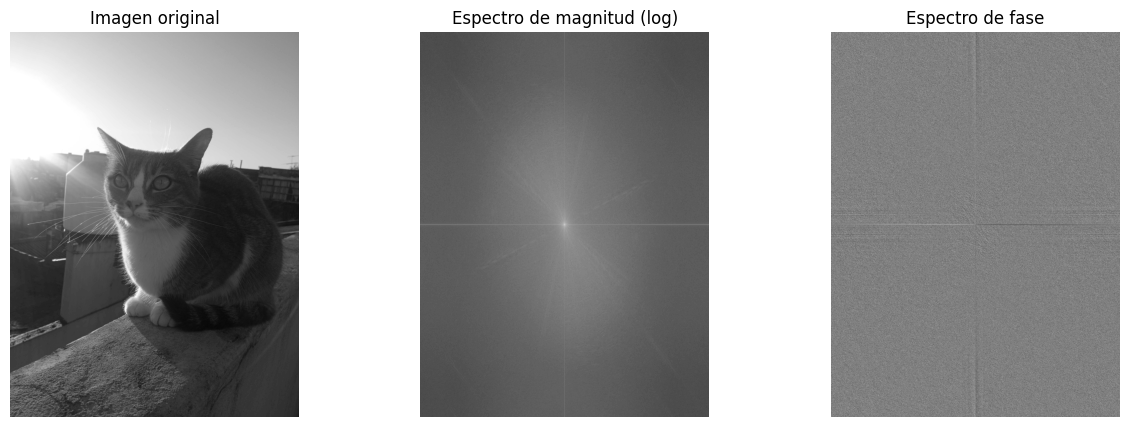

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1. Cargar imagen en escala de grises
img = Image.open("cirisol.jpg").convert("L")  # "L" = grayscale
img_array = np.array(img)

# 2. FFT 2D
fft2 = np.fft.fft2(img_array)
fft2_shifted = np.fft.fftshift(fft2)  # centramos el espectro

# 3. Magnitud y fase
magnitude = np.abs(fft2_shifted)
phase = np.angle(fft2_shifted)

# 4. Mostrar resultados
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_array, cmap="gray")
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(np.log1p(magnitude), cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(phase, cmap="gray")
plt.title("Espectro de fase")
plt.axis("off")

plt.show()